In [1]:
# general imports
import random
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.utils.data as utils
from torch.autograd import Variable
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
plt.rcParams["legend.loc"] = "best"
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

In [2]:
# filter python warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# prepare CIFAR data

# normalize
scale = np.mean(np.arange(0, 256))
normalize = lambda x: (x - scale) / scale

# train data
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar_train_images = normalize(cifar_trainset.train_data)
cifar_train_labels = np.array(cifar_trainset.train_labels)

# test data
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
cifar_test_images = normalize(cifar_testset.test_data)
cifar_test_labels = np.array(cifar_testset.test_labels)

# print(np.min(cifar_train_images))
# print(np.max(cifar_train_images))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# The Deep Convolution Random Forest class (for binary classification)
class ConvRF(object):
    def __init__(self, kernel_size=5, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
        self.kernel_forests = None

    def _convolve_chop(self, images, labels=None, flatten=False):

        batch_size, in_dim, _, num_channels = images.shape

        out_dim = int((in_dim - self.kernel_size) / self.stride) + 1  # calculate output dimensions

        # create matrix to hold the chopped images
        out_images = np.zeros((batch_size, out_dim, out_dim,
                               self.kernel_size, self.kernel_size, num_channels))
        out_labels = None

        curr_y = out_y = 0
        # move kernel vertically across the image
        while curr_y + self.kernel_size <= in_dim:
            curr_x = out_x = 0
            # move kernel horizontally across the image
            while curr_x + self.kernel_size <= in_dim:
                # chop images
                out_images[:, out_x, out_y] = images[:, curr_x:curr_x +
                                                     self.kernel_size, curr_y:curr_y+self.kernel_size, :]
                curr_x += self.stride
                out_x += 1
            curr_y += self.stride
            out_y += 1

        if flatten:
            out_images = out_images.reshape(batch_size, out_dim, out_dim, -1)

        if labels is not None:
            out_labels = np.zeros((batch_size, out_dim, out_dim))
            out_labels[:, ] = labels.reshape(-1, 1, 1)

        return out_images, out_labels

    def convolve_fit(self, images, labels):
        num_channels = images.shape[-1]
        sub_images, sub_labels = self._convolve_chop(images, labels=labels, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        self.kernel_forests = np.zeros((out_dim, out_dim), dtype=np.int).tolist()
        convolved_image = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                self.kernel_forests[i][j] = RandomForestClassifier(n_estimators=32)
                self.kernel_forests[i][j].fit(sub_images[:, i, j], sub_labels[:, i, j])
                convolved_image[:, i, j] = self.kernel_forests[i][j].predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return convolved_image

    def convolve_predict(self, images):
        if not self.kernel_forests:
            raise Exception("Should fit training data before predicting")

        num_channels = images.shape[-1]
        sub_images, _ = self._convolve_chop(images, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        
        kernel_predictions = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                kernel_predictions[:, i, j] = self.kernel_forests[i][j].predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return kernel_predictions

In [5]:
# define a simple CNN arhcitecture
from torch.autograd import Variable
import torch.nn.functional as F

class SimpleCNNOneFilter(torch.nn.Module):
    
    def __init__(self):
        super(SimpleCNNOneFilter, self).__init__()        
        self.conv1 = torch.nn.Conv2d(3, 1, kernel_size=10, stride=2)
        self.fc1 = torch.nn.Linear(144, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 144)
        x = self.fc1(x)
        return(x)

class SimpleCNN32Filter(torch.nn.Module):
    
    def __init__(self):
        super(SimpleCNN32Filter, self).__init__()        
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=10, stride=2) # try 64 too, if possible
        self.fc1 = torch.nn.Linear(144*32, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 144*32)
        x = self.fc1(x)
        return(x)

class SimpleCNN32Filter2Layers(torch.nn.Module):
    
    def __init__(self):
        super(SimpleCNN32Filter2Layers, self).__init__()        
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=10, stride=2)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=7, stride=1)
        self.fc1 = torch.nn.Linear(36*32, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 36*32)
        x = self.fc1(x)
        return(x)

In [6]:
def run_naive_rf(train_images, train_labels, test_images, test_labels, fraction_of_train_samples, class1=3, class2=5):
    num_train_samples_class_1 = int(np.sum(train_labels==class1) * fraction_of_train_samples)
    num_train_samples_class_2 = int(np.sum(train_labels==class2) * fraction_of_train_samples)
    
    # get only train images and labels for class 1 and class 2
    train_images = np.concatenate([train_images[train_labels==class1][:num_train_samples_class_1], train_images[train_labels==class2][:num_train_samples_class_2]])
    train_labels = np.concatenate([np.repeat(0, num_train_samples_class_1), np.repeat(1, num_train_samples_class_2)])

    # get only test images and labels for class 1 and class 2
    test_images = np.concatenate([test_images[test_labels==class1], test_images[test_labels==class2]])
    test_labels = np.concatenate([np.repeat(0, np.sum(test_labels==class1)), np.repeat(1, np.sum(test_labels==class2))])

    # Train
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(train_images.reshape(-1, 32*32*3), train_labels)
    # Test
    test_preds = clf.predict(test_images.reshape(-1, 32*32*3))
    return accuracy_score(test_labels, test_preds)

In [7]:
def run_one_layer_deep_conv_rf(train_images, train_labels, test_images, test_labels, fraction_of_train_samples, class1=3, class2=5):
    num_train_samples_class_1 = int(np.sum(train_labels==class1) * fraction_of_train_samples)
    num_train_samples_class_2 = int(np.sum(train_labels==class2) * fraction_of_train_samples)
    
    # get only train images and labels for class 1 and class 2
    train_images = np.concatenate([train_images[train_labels==class1][:num_train_samples_class_1], train_images[train_labels==class2][:num_train_samples_class_2]])
    train_labels = np.concatenate([np.repeat(0, num_train_samples_class_1), np.repeat(1, num_train_samples_class_2)])

    # get only test images and labels for class 1 and class 2
    test_images = np.concatenate([test_images[test_labels==class1], test_images[test_labels==class2]])
    test_labels = np.concatenate([np.repeat(0, np.sum(test_labels==class1)), np.repeat(1, np.sum(test_labels==class2))])
    
    ## Train
    # ConvRF (layer 1)
    conv1 = ConvRF(kernel_size=15, stride=2)
    conv1_map = conv1.convolve_fit(train_images, train_labels)

    # Full RF
    conv1_full_RF = RandomForestClassifier(n_estimators=100)
    conv1_full_RF.fit(conv1_map.reshape(len(train_images), -1), train_labels)

    ## Test (after ConvRF 1 and Full RF)
    conv1_map_test = conv1.convolve_predict(test_images)
    mnist_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(test_images), -1))

    return accuracy_score(test_labels, mnist_test_preds)

In [8]:
def run_two_layer_deep_conv_rf(train_images, train_labels, test_images, test_labels, fraction_of_train_samples, class1=3, class2=8):
    num_train_samples_class_1 = int(np.sum(train_labels==class1) * fraction_of_train_samples)
    num_train_samples_class_2 = int(np.sum(train_labels==class2) * fraction_of_train_samples)
    
    # get only train images and labels for class 1 and class 2
    train_images = np.concatenate([train_images[train_labels==class1][:num_train_samples_class_1], train_images[train_labels==class2][:num_train_samples_class_2]])
    train_labels = np.concatenate([np.repeat(0, num_train_samples_class_1), np.repeat(1, num_train_samples_class_2)])

    # get only test images and labels for class 1 and class 2
    test_images = np.concatenate([test_images[test_labels==class1], test_images[test_labels==class2]])
    test_labels = np.concatenate([np.repeat(0, np.sum(test_labels==class1)), np.repeat(1, np.sum(test_labels==class2))])
    
    ## Train
    # ConvRF (layer 1)
    conv1 = ConvRF(kernel_size=15, stride=2)
    conv1_map = conv1.convolve_fit(train_images, train_labels)
    
    # ConvRF (layer 2)
    conv2 = ConvRF(kernel_size=5, stride=1)
    conv2_map = conv2.convolve_fit(conv1_map, train_labels)

    # Full RF
    conv1_full_RF = RandomForestClassifier(n_estimators=100)
    conv1_full_RF.fit(conv2_map.reshape(len(train_images), -1), train_labels)

    ## Test (after ConvRF 1 and Full RF)
    conv1_map_test = conv1.convolve_predict(test_images)
    conv2_map_test = conv2.convolve_predict(conv1_map_test)
    test_preds = conv1_full_RF.predict(conv2_map_test.reshape(len(test_images), -1))

    return accuracy_score(test_labels, test_preds)

In [9]:
# transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

def cnn_train_test(cnn_model, y_train, y_test, fraction_of_train_samples, class1=3, class2=5):
    # set params
    num_epochs = 5
    learning_rate = 0.001

    class1_indices = np.argwhere(y_train==class1).flatten()
    class1_indices = class1_indices[:int(len(class1_indices) * fraction_of_train_samples)]
    class2_indices = np.argwhere(y_train==class2).flatten()
    class2_indices = class2_indices[:int(len(class2_indices) * fraction_of_train_samples)]
    train_indices = np.concatenate([class1_indices, class2_indices])

    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, num_workers=2, sampler=train_sampler)

    test_indices = np.concatenate([np.argwhere(y_test==class1).flatten(), np.argwhere(y_test==class2).flatten()])
    test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

    test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                             shuffle=False, num_workers=2, sampler=test_sampler)

    # define model
    net = cnn_model()

    # loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # test the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.view(-1)).sum().item()
    accuracy = float(correct) / float(total)
    return accuracy

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def run_cnn(cnn_model, train_images, train_labels, test_images, test_labels, fraction_of_train_samples, class1=3, class2=5):
    return cnn_train_test(cnn_model, train_labels, test_labels, fraction_of_train_samples, class1, class2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0


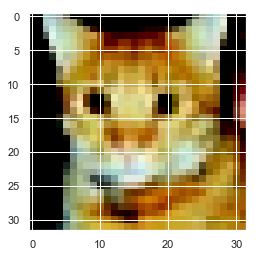

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 1


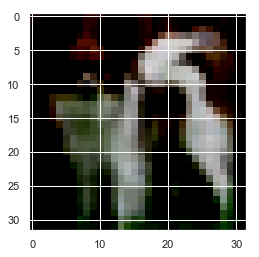

In [11]:
# 3 (cat) vs 5 (dog) classification

# get only train images and labels for two classes: 3 and 8
cifar_train_images_3_5 = np.concatenate([cifar_train_images[cifar_train_labels==3], cifar_train_images[cifar_train_labels==5]])
cifar_train_labels_3_5 = np.concatenate([np.repeat(0, np.sum(cifar_train_labels==3)), np.repeat(1, np.sum(cifar_train_labels==5))])

# visualize data and labels

# 3 (label 0) - cat
index = 2500
print("Label:", cifar_train_labels_3_5[index])
plt.imshow(cifar_train_images_3_5[index])
plt.show()

# 5 (label 1) - dog
index = 7500
print("Label:", cifar_train_labels_3_5[index])
plt.imshow(cifar_train_images_3_5[index])
plt.show()

In [12]:
# accuracy vs num training samples (naive_rf)
naive_rf_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = np.mean([run_naive_rf(cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples, 3, 5) for _ in range(3)])
    naive_rf_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.5025
Train Fraction: 0.016681005372000592
Accuracy: 0.5458333333333334
Train Fraction: 0.027825594022071243
Accuracy: 0.5548333333333333
Train Fraction: 0.046415888336127774
Accuracy: 0.5671666666666667
Train Fraction: 0.0774263682681127
Accuracy: 0.5935
Train Fraction: 0.1291549665014884
Accuracy: 0.6175
Train Fraction: 0.21544346900318834
Accuracy: 0.6256666666666667
Train Fraction: 0.3593813663804626
Accuracy: 0.6525
Train Fraction: 0.5994842503189409
Accuracy: 0.6526666666666667
Train Fraction: 1.0
Accuracy: 0.6628333333333333


In [13]:
# accuracy vs num training samples (one layer deep_conv_rf)
deep_conv_rf_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = np.mean([run_one_layer_deep_conv_rf(cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples, 3, 5) for _ in range(3)])
    deep_conv_rf_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.4945
Train Fraction: 0.016681005372000592
Accuracy: 0.5268333333333334
Train Fraction: 0.027825594022071243
Accuracy: 0.5821666666666667
Train Fraction: 0.046415888336127774
Accuracy: 0.6023333333333333
Train Fraction: 0.0774263682681127
Accuracy: 0.6121666666666666
Train Fraction: 0.1291549665014884
Accuracy: 0.628
Train Fraction: 0.21544346900318834
Accuracy: 0.6488333333333333
Train Fraction: 0.3593813663804626
Accuracy: 0.6658333333333334
Train Fraction: 0.5994842503189409
Accuracy: 0.6705
Train Fraction: 1.0
Accuracy: 0.6776666666666666


In [14]:
# accuracy vs num training samples (one layer cnn)
cnn_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = np.mean([run_cnn(SimpleCNNOneFilter, cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples, 3, 5) for _ in range(3)])
    cnn_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.5113333333333333
Train Fraction: 0.016681005372000592
Accuracy: 0.5263333333333334
Train Fraction: 0.027825594022071243
Accuracy: 0.5406666666666667
Train Fraction: 0.046415888336127774
Accuracy: 0.5366666666666667
Train Fraction: 0.0774263682681127
Accuracy: 0.5511666666666667
Train Fraction: 0.1291549665014884
Accuracy: 0.548
Train Fraction: 0.21544346900318834
Accuracy: 0.5585
Train Fraction: 0.3593813663804626
Accuracy: 0.5668333333333333
Train Fraction: 0.5994842503189409
Accuracy: 0.5831666666666667
Train Fraction: 1.0
Accuracy: 0.5801666666666667


In [15]:
# accuracy vs num training samples (one layer cnn (32 filters))
cnn32_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = np.mean([run_cnn(SimpleCNN32Filter, cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples, 3, 5) for _ in range(3)])
    cnn32_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.4845
Train Fraction: 0.016681005372000592
Accuracy: 0.5248333333333334
Train Fraction: 0.027825594022071243
Accuracy: 0.5195
Train Fraction: 0.046415888336127774
Accuracy: 0.5528333333333333
Train Fraction: 0.0774263682681127
Accuracy: 0.5619999999999999
Train Fraction: 0.1291549665014884
Accuracy: 0.5950000000000001
Train Fraction: 0.21544346900318834
Accuracy: 0.6141666666666667
Train Fraction: 0.3593813663804626
Accuracy: 0.6341666666666667
Train Fraction: 0.5994842503189409
Accuracy: 0.628
Train Fraction: 1.0
Accuracy: 0.6629999999999999


In [16]:
# accuracy vs num training samples (two layer deep_conv_rf)
deep_conv_rf_two_layer_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = np.mean([run_two_layer_deep_conv_rf(cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples, 3, 5) for _ in range(3)])
    deep_conv_rf_two_layer_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.49700000000000005
Train Fraction: 0.016681005372000592
Accuracy: 0.5205000000000001
Train Fraction: 0.027825594022071243
Accuracy: 0.5661666666666667
Train Fraction: 0.046415888336127774
Accuracy: 0.6013333333333334
Train Fraction: 0.0774263682681127
Accuracy: 0.6076666666666667
Train Fraction: 0.1291549665014884
Accuracy: 0.6193333333333334
Train Fraction: 0.21544346900318834
Accuracy: 0.6436666666666666
Train Fraction: 0.3593813663804626
Accuracy: 0.6628333333333333
Train Fraction: 0.5994842503189409
Accuracy: 0.6541666666666667
Train Fraction: 1.0
Accuracy: 0.6755


In [17]:
# accuracy vs num training samples (two layer cnn (32 filters))
cnn32_two_layer_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = np.mean([run_cnn(SimpleCNN32Filter2Layers, cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples, 3, 5) for _ in range(3)])
    cnn32_two_layer_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.48
Train Fraction: 0.016681005372000592
Accuracy: 0.5091666666666667
Train Fraction: 0.027825594022071243
Accuracy: 0.5323333333333333
Train Fraction: 0.046415888336127774
Accuracy: 0.5713333333333334
Train Fraction: 0.0774263682681127
Accuracy: 0.5661666666666667
Train Fraction: 0.1291549665014884
Accuracy: 0.5898333333333333
Train Fraction: 0.21544346900318834
Accuracy: 0.6191666666666666
Train Fraction: 0.3593813663804626
Accuracy: 0.6351666666666667
Train Fraction: 0.5994842503189409
Accuracy: 0.6575000000000001
Train Fraction: 1.0
Accuracy: 0.6901666666666667


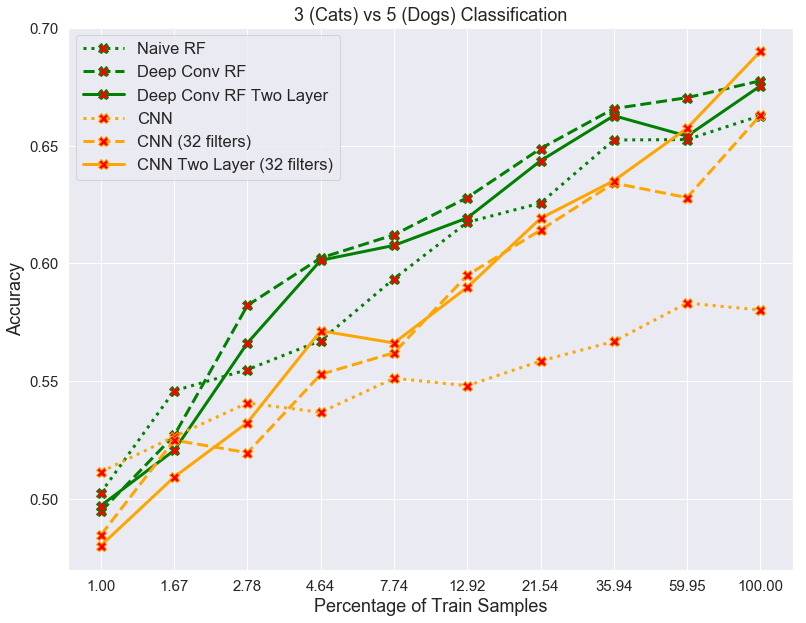

In [18]:
plt.rcParams['figure.figsize'] = 13, 10
plt.rcParams['font.size'] = 25
plt.rcParams['legend.fontsize'] = 16.5
plt.rcParams['legend.handlelength'] = 2.5
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

fig, ax = plt.subplots() # create a new figure with a default 111 subplot
ax.plot(fraction_of_train_samples_space*100, naive_rf_acc_vs_n, marker='X', markerfacecolor='red', markersize=10, color='green', linewidth=3, linestyle=":", label="Naive RF")
ax.plot(fraction_of_train_samples_space*100, deep_conv_rf_acc_vs_n, marker='X', markerfacecolor='red', markersize=10, color='green', linewidth=3, linestyle="--", label="Deep Conv RF")
ax.plot(fraction_of_train_samples_space*100, deep_conv_rf_two_layer_acc_vs_n, marker='X', markerfacecolor='red', markersize=10, color='green', linewidth=3, label="Deep Conv RF Two Layer")

ax.plot(fraction_of_train_samples_space*100, cnn_acc_vs_n, marker='X', markerfacecolor='red', markersize=10, color='orange', linewidth=3, linestyle=":", label="CNN")
ax.plot(fraction_of_train_samples_space*100, cnn32_acc_vs_n, marker='X', markerfacecolor='red', markersize=10, color='orange', linewidth=3, linestyle="--", label="CNN (32 filters)")
ax.plot(fraction_of_train_samples_space*100, cnn32_two_layer_acc_vs_n, marker='X', markerfacecolor='red', markersize=10, color='orange', linewidth=3, label="CNN Two Layer (32 filters)")

ax.set_xlabel('Percentage of Train Samples', fontsize=18)
ax.set_xscale('log')
ax.set_xticks([i*100 for i in list(np.geomspace(0.01, 1.0, num=10))])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_ylabel('Accuracy', fontsize=18)
# ax.set_ylim(0.68, 1)

ax.set_title("3 (Cats) vs 5 (Dogs) Classification", fontsize=18)
plt.legend()
plt.show()